# Decision Tree & Random Forest for WU Data

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import random
import datetime
import sklearn
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")    


/Users/danny/opt/anaconda3/envs/Capstone/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data Modeling/WU'

## Read Data

In [3]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data')

In [4]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

,timestamp,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precip.,Operational Demand (MW)
0,2006-09-20 00:00:00,13.89,12.22,88.0,5.0,0.0,30.0,0.0,1347.418
1,2006-09-20 00:30:00,13.89,12.22,88.0,13.0,0.0,30.0,0.0,1312.708
2,2006-09-20 01:00:00,13.89,10.00,77.0,8.0,0.0,30.0,0.0,1298.644
3,2006-09-20 01:30:00,13.89,11.11,82.0,8.0,0.0,30.0,0.0,1288.972
4,2006-09-20 02:00:00,15.00,12.22,82.0,10.0,0.0,30.0,0.0,1282.006


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270281 entries, 0 to 270280
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   timestamp                270281 non-null  object 
 1   Temperature              270281 non-null  float64
 2   Dew Point                270281 non-null  float64
 3   Humidity                 270281 non-null  float64
 4   Wind Speed               270281 non-null  float64
 5   Wind Gust                270281 non-null  float64
 6   Pressure                 270281 non-null  float64
 7   Precip.                  270281 non-null  float64
 8   Operational Demand (MW)  270281 non-null  float64
dtypes: float64(8), object(1)
memory usage: 20.6+ MB


In [6]:
df = df.rename(columns={'Temperature':'temperature(celcius)', 'Dew Point':'dew_point(celcius)', 'Humidity':'humidity(%)', 'Wind Speed':'wind_speed(mph)',
       'Wind Gust':'wind_gush(mph)', 'Pressure':'pressure(in)', 'Precip.':'precip.(in)'})

In [7]:
df.columns

Index(['timestamp', 'temperature(celcius)', 'dew_point(celcius)',
       'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
       'precip.(in)', 'Operational Demand (MW)'],
      dtype='object')

## Data Preparation

In [8]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return 1 
    else:
        return 0
# split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
def create_time_features(df_in):
    df_in[['Date','Trading Interval Time']] = df_in['timestamp'].str.split(" ",expand=True)
    df_in['Date'] = pd.to_datetime(df_in['Date'])
    df_in['new_timestamp'] = pd.to_datetime(df_in['timestamp'], errors='coerce')
    df_in['year'] = df_in['new_timestamp'].dt.year
    df_in['month'] = df_in['new_timestamp'].dt.month
    df_in['day'] = df_in['new_timestamp'].dt.day
    df_in['hour'] = df_in['new_timestamp'].dt.hour
    df_in['minute'] = df_in['new_timestamp'].dt.minute
    df_in['Day_of_week'] = df_in['new_timestamp'].dt.dayofweek
    df_in['Day_of_month'] = df_in['new_timestamp'].dt.day
    df_in['Day_of_year'] = df_in['new_timestamp'].dt.dayofyear
    df_in['has_Wind'] = df_in['wind_speed(mph)'].apply(wind_ans) 
    df_in.set_index('timestamp', inplace=True, drop=True)
    df_in.reset_index(inplace=True)
    df_in.index = df_in['timestamp']
    df_out = df_in
    return df_out
df = create_time_features(df)
df.head()

,timestamp,temperature(celcius),dew_point(celcius),humidity(%),wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),Operational Demand (MW),Date,...,new_timestamp,year,month,day,hour,minute,Day_of_week,Day_of_month,Day_of_year,has_Wind
timestamp,,,,,,,,,,,,,,,,,,,,,
2006-09-20 00:00:00,2006-09-20 00:00:00,13.89,12.22,88.0,5.0,0.0,30.0,0.0,1347.418,2006-09-20,...,2006-09-20 00:00:00,2006,9,20,0,0,2,20,263,1
2006-09-20 00:30:00,2006-09-20 00:30:00,13.89,12.22,88.0,13.0,0.0,30.0,0.0,1312.708,2006-09-20,...,2006-09-20 00:30:00,2006,9,20,0,30,2,20,263,1
2006-09-20 01:00:00,2006-09-20 01:00:00,13.89,10.00,77.0,8.0,0.0,30.0,0.0,1298.644,2006-09-20,...,2006-09-20 01:00:00,2006,9,20,1,0,2,20,263,1
2006-09-20 01:30:00,2006-09-20 01:30:00,13.89,11.11,82.0,8.0,0.0,30.0,0.0,1288.972,2006-09-20,...,2006-09-20 01:30:00,2006,9,20,1,30,2,20,263,1
2006-09-20 02:00:00,2006-09-20 02:00:00,15.00,12.22,82.0,10.0,0.0,30.0,0.0,1282.006,2006-09-20,...,2006-09-20 02:00:00,2006,9,20,2,0,2,20,263,1


In [9]:
# def create_time_features(df_in):
#     df = df_in
#     df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#     df['Year'] = df['timestamp'].dt.year
#     df['Month'] = df['timestamp'].dt.month
#     df['Hour'] = df['timestamp'].dt.hour
#     df['Day_of_week'] = df['timestamp'].dt.dayofweek
#     df['Day_of_month'] = df['timestamp'].dt.day
#     df['Day_of_year'] = df['timestamp'].dt.dayofyear
#     df.set_index('timestamp', inplace=True, drop=True)
#     # df = df.astype('int')
#     df.reset_index(inplace=True)
#     time_features_df = df
#     return time_features_df
# df_a = create_time_features(df)
# df_a.columns.tolist()
# df_a.head()

In [10]:
#select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'year','Day_of_week','Day_of_month','Day_of_year']
select_col = ['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
'Day_of_week', 'Day_of_month', 'Day_of_year','year','hour','minute']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))
model_df=df[select_col]
# training_dat = model_df[(model_df.index < '2020-12-01') | ('2021-04-01' <= model_df.index)]
training_dat = model_df[model_df.index < '2021-12-01']
testing_dat = model_df[(model_df.index >= '2021-12-01') & ('2022-04-01' > model_df.index)]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']


## Function Preparation

In [11]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [12]:
# stdsc=StandardScaler()
# X_train_sc = stdsc.fit_transform(X_train)
# X_test_sc = stdsc.transform(X_test)

## Threshold Determine

125225.874

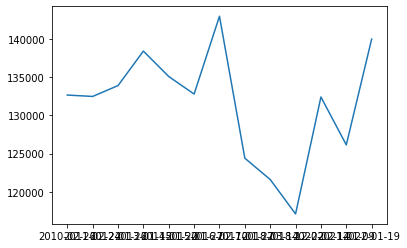

In [13]:
agg_all = model_df.copy()
agg_all['Date','time'] = agg_all.index.str.split(" ",expand=True)
agg_all[['Date', 'time']] = agg_all[('Date', 'time')].apply(pd.Series)

agg_all = agg_all.drop(labels=['time',('Date','time')], axis=1)
agg_all = pd.DataFrame(agg_all.groupby(['Date'])['Operational Demand (MW)'].sum())
new_df_summer = pd.DataFrame()
for i in range(2009,2022):
    s0 = str(i) + '-12-01'
    s1 = str(i+1) + '-04-01'
    df_summer = agg_all[(agg_all.index >= s0) & (s1 > agg_all.index)]
    order_table = df_summer.sort_values('Operational Demand (MW)',ascending=False)
    nr = order_table[3:4]
    new_df_summer = pd.concat((new_df_summer,nr))
od = new_df_summer['Operational Demand (MW)']
plt.plot(od.index,od)
year_choose = 3 # number of year we choose to get the average threshold
ave_threshold = sum(od[-4:-1])/year_choose
# ave_threshold= sum(od[:-1])/len(od[:-1])   
ave_threshold # same result for both threshold

In [14]:
od[:-1]

Date
2010-02-26    132645.194
2011-02-24    132465.406
2012-01-26    133880.634
2013-01-15    138378.508
2014-01-20    135063.762
2015-01-27    132775.894
2016-02-10    142928.122
2017-01-27    124407.598
2018-03-14    121625.992
2018-12-22    117137.326
2020-02-14    132391.970
2021-01-09    126148.326
Name: Operational Demand (MW), dtype: float64

## Decision Tree

In [15]:
tree_reg = DecisionTreeRegressor(random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree = grid_dtree.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.9s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.8s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.9s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.7s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.7s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.7s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.7s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.7s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.7s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.8s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.9s
[CV] END ...................max_depth=15, min_sa

In [16]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('grid_dtree')
print(grid_dtree.best_estimator_)

Mean absolute error =  188.6891
Mean squared error =  64929.2385
Median absolute error =  133.9563
explained variance error =  0.814
R2 error =  0.7937
Mape 8.552636878032244
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     pressure(in)     | 0.2181 |
|     Day_of_month     | 0.0187 |
|  dew_point(celcius)  | 0.019  |
|    wind_gush(mph)    | 0.0014 |
|     Day_of_week      |  0.0   |
|        minute        | 0.001  |
|     humidity(%)      | 0.0711 |
| temperature(celcius) | 0.0026 |
|         year         | 0.0554 |
|   wind_speed(mph)    | 0.1253 |
|         hour         | 0.4846 |
|     Day_of_year      | 0.003  |
+----------------------+--------+
DecisionTreeRegressor(max_depth=25, min_samples_leaf=50, random_state=42)


In [17]:
# fig = plt.figure(figsize=(16,12))
# a_rf_smote = plot_tree(grid_dtree.best_estimator_, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [18]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_tree = pd.DataFrame(y_test)
predict_table_tree.insert(1,'predict',y_pred_tree)
predict_table_tree

,Operational Demand (MW),predict
timestamp,,
2021-12-01 00:00:00,1788.716,1742.371213
2021-12-01 00:30:00,1768.478,1742.371213
2021-12-01 01:00:00,1756.662,1793.243867
2021-12-01 01:30:00,1735.248,1793.243867
2021-12-01 02:00:00,1724.418,1793.243867
...,...,...
2022-03-31 21:30:00,2496.326,2447.144925
2022-03-31 22:00:00,2418.866,2247.078337
2022-03-31 22:30:00,2323.210,2247.078337


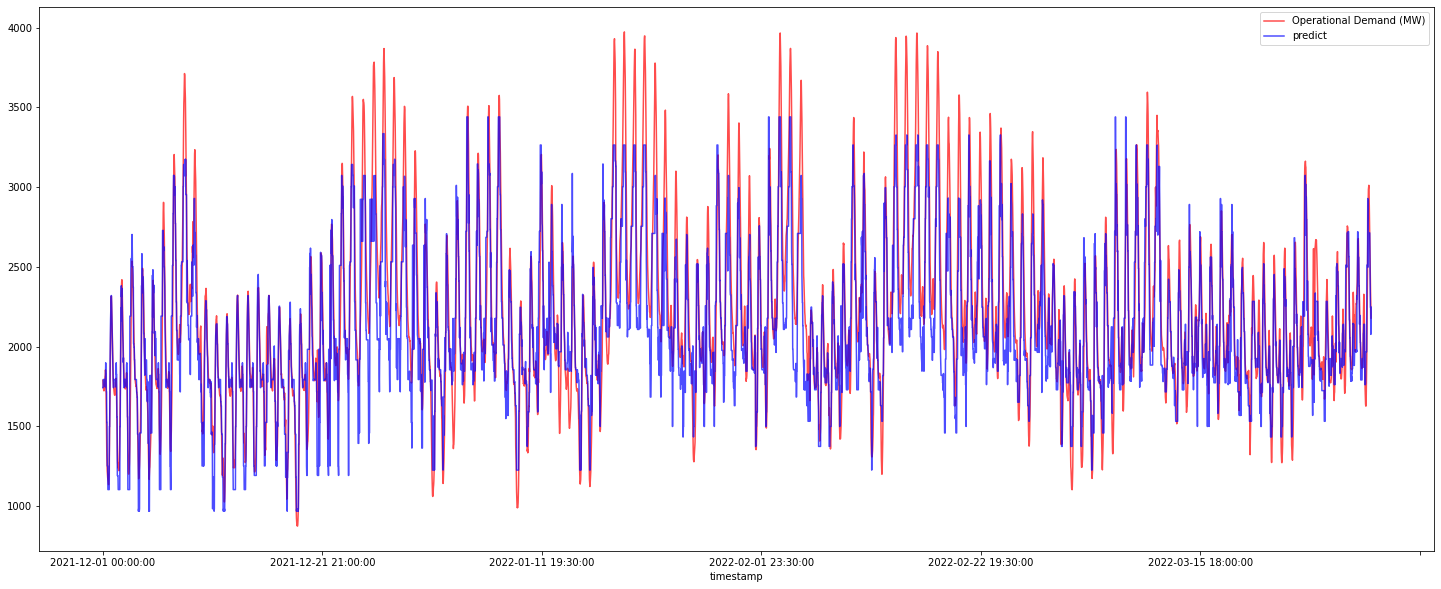

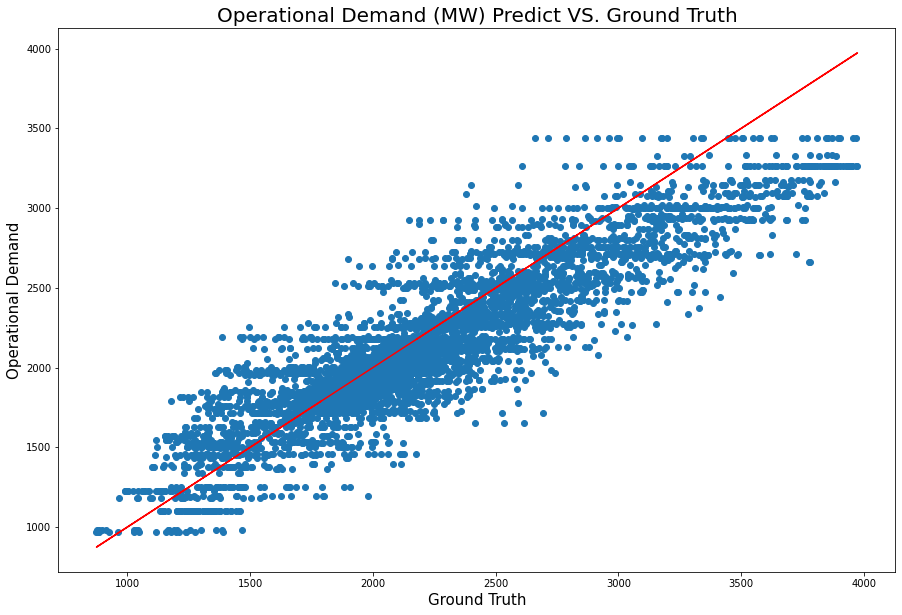

In [19]:
predict_table_tree.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [20]:
predict_table_tree['Date','time'] = predict_table_tree.index.str.split(" ",expand=True)
predict_table_tree[['Date', 'time']] = predict_table_tree[('Date', 'time')].apply(pd.Series)

predict_table_tree = predict_table_tree.drop(labels=['time',('Date','time')], axis=1)
agg_tree = pd.DataFrame(predict_table_tree.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())


In [21]:
tree_plot = agg_tree.copy()
tree_plot.index = tree_plot['Date']
tree_plot.drop('Date',axis=1)

,Operational Demand (MW),predict
Date,,
2021-12-01,81389.002,82827.468064
2021-12-02,83692.208,82214.838144
2021-12-03,87674.768,91165.962259
2021-12-04,86230.014,84826.795332
2021-12-05,83724.146,87095.714174
...,...,...
2022-03-27,94461.504,89254.908205
2022-03-28,96458.404,99039.506348
2022-03-29,100749.966,103491.947260


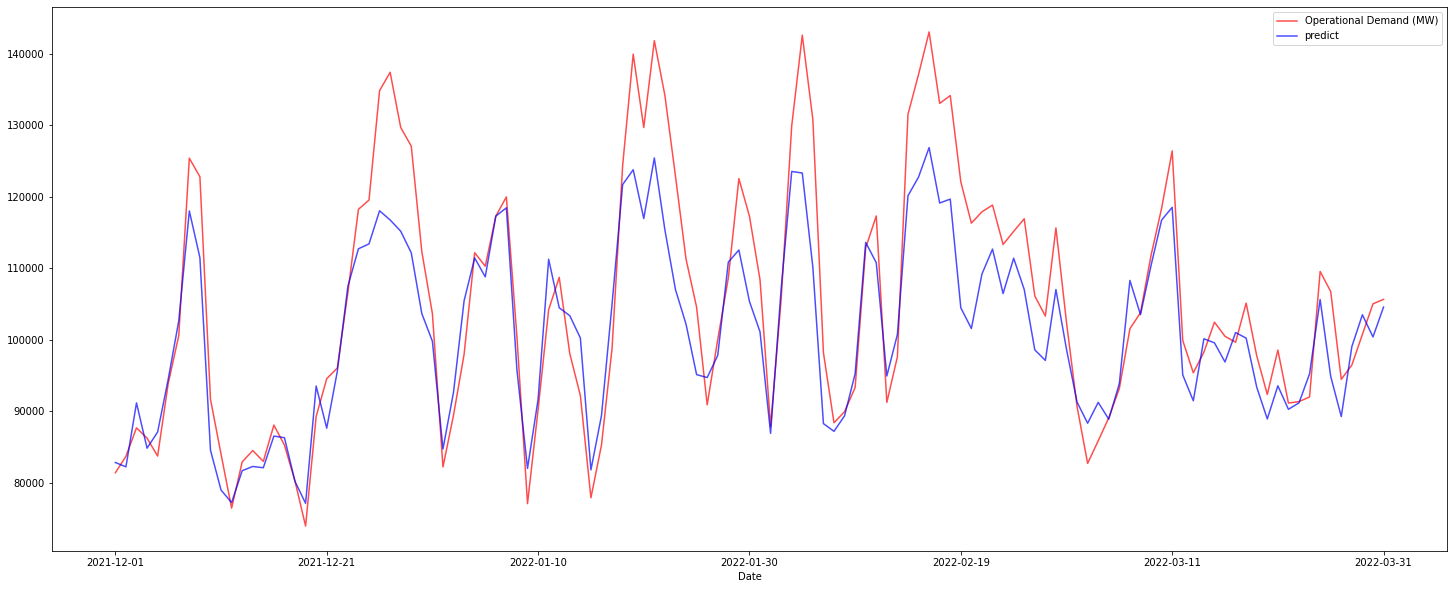

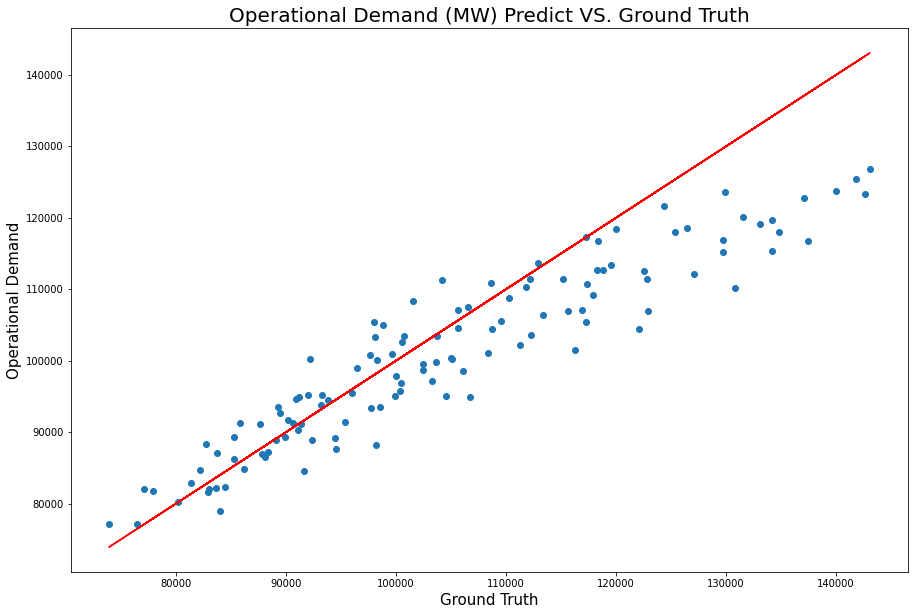

In [22]:
tree_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(tree_plot['Operational Demand (MW)'], tree_plot['predict'])
plt.plot(tree_plot['Operational Demand (MW)'],tree_plot['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [23]:
peak_day = 5 # number of top peak day we choose
peak_true = agg_tree.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = agg_tree.sort_values('predict',ascending=False)[:peak_day]
peak_predict = agg_tree[agg_tree['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.4


## Random Forest

In [24]:
forest = RandomForestRegressor(random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train,y_train)
y_predict_forest = grid_forest.predict(X_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  54.7s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  56.3s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  57.4s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  41.5s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  41.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  40.4s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=  37.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=  37.3s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=  37.7s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  44.5s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  44.7s
[CV] END ...................max_depth=15, min_sa

In [25]:
ny_test = len(y_test)
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('Mape', mape)
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
ImportanceDisplay('grid_forest')
print(grid_forest.best_estimator_)

Mape 7.261507583197645
Mean absolute error =  158.5368
Mean squared error =  46367.2774
Median absolute error =  112.8435
explained variance error =  0.8648
R2 error =  0.8527
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     pressure(in)     | 0.2113 |
|     Day_of_month     | 0.022  |
|  dew_point(celcius)  | 0.0205 |
|    wind_gush(mph)    | 0.0057 |
|     Day_of_week      | 0.0002 |
|        minute        | 0.0014 |
|     humidity(%)      | 0.0708 |
| temperature(celcius) | 0.0095 |
|         year         | 0.0669 |
|   wind_speed(mph)    | 0.1251 |
|         hour         | 0.4629 |
|     Day_of_year      | 0.0038 |
+----------------------+--------+
RandomForestRegressor(max_depth=25, min_samples_leaf=5, random_state=42)


In [26]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table_forest = pd.DataFrame(y_test)
predict_table_forest.insert(1,'predict',y_predict_forest)
predict_table_forest

,Operational Demand (MW),predict
timestamp,,
2021-12-01 00:00:00,1788.716,1812.178714
2021-12-01 00:30:00,1768.478,1802.091058
2021-12-01 01:00:00,1756.662,1764.833078
2021-12-01 01:30:00,1735.248,1763.619010
2021-12-01 02:00:00,1724.418,1760.639790
...,...,...
2022-03-31 21:30:00,2496.326,2392.787177
2022-03-31 22:00:00,2418.866,2285.969818
2022-03-31 22:30:00,2323.210,2252.129789


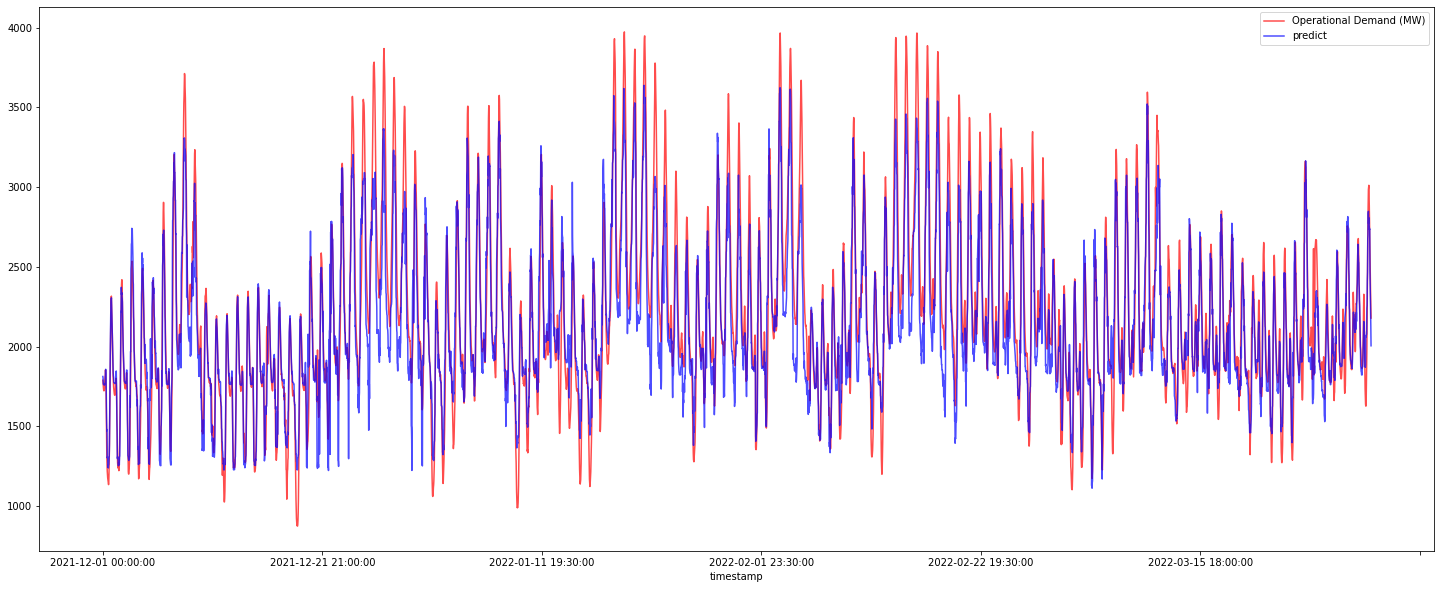

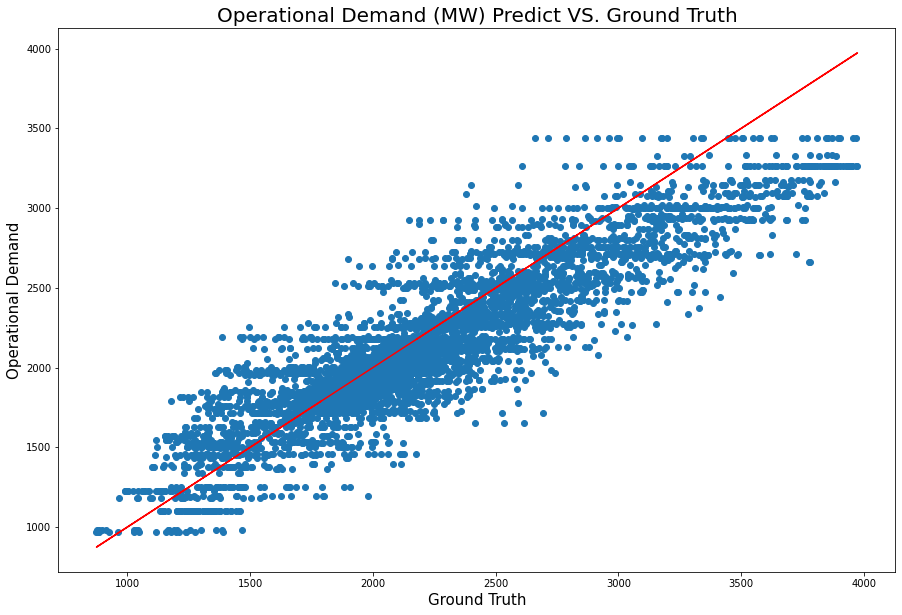

In [27]:
predict_table_forest.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [28]:
predict_table_forest['Date','time'] = predict_table_forest.index.str.split(" ",expand=True)
predict_table_forest[['Date', 'time']] = predict_table_forest[('Date', 'time')].apply(pd.Series)

predict_table_forest = predict_table_forest.drop(labels=['time',('Date','time')], axis=1)
agg_forest = pd.DataFrame(predict_table_forest.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())

In [29]:
forest_plot = agg_forest.copy()
forest_plot.index = forest_plot['Date']
forest_plot.drop('Date',axis=1)

,Operational Demand (MW),predict
Date,,
2021-12-01,81389.002,83539.453562
2021-12-02,83692.208,84131.083207
2021-12-03,87674.768,91649.239312
2021-12-04,86230.014,88909.284500
2021-12-05,83724.146,90852.546994
...,...,...
2022-03-27,94461.504,89227.920722
2022-03-28,96458.404,99324.691006
2022-03-29,100749.966,104165.367873


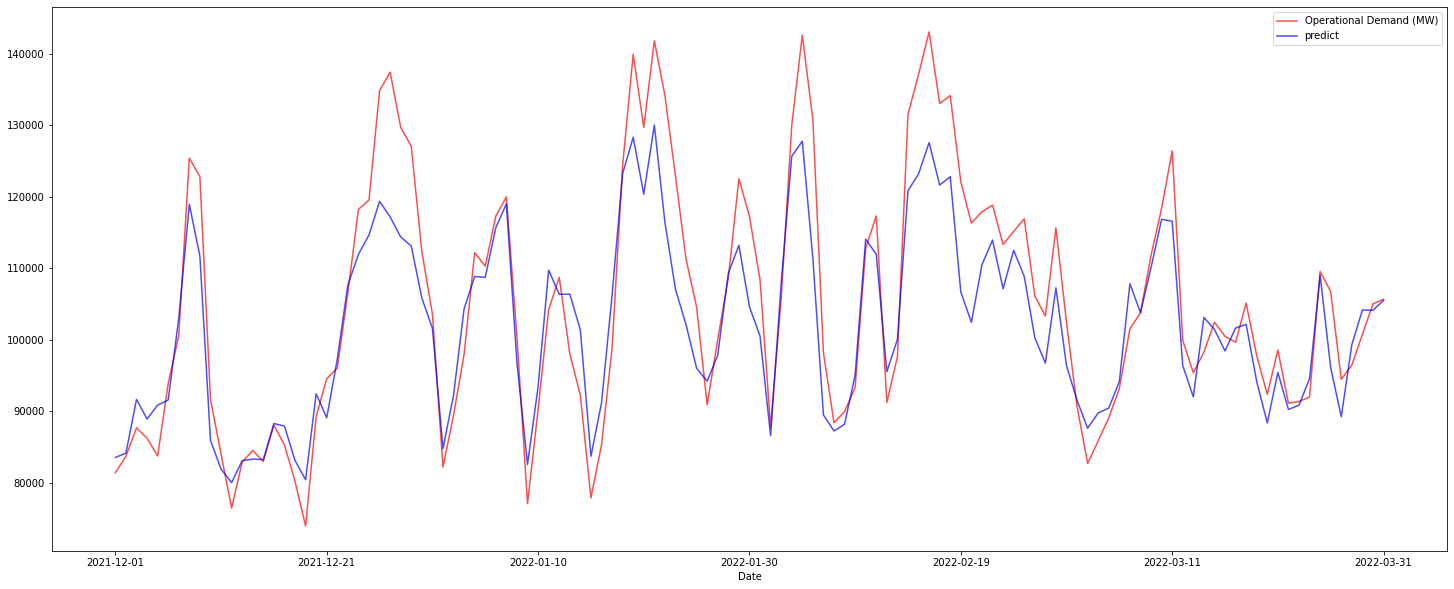

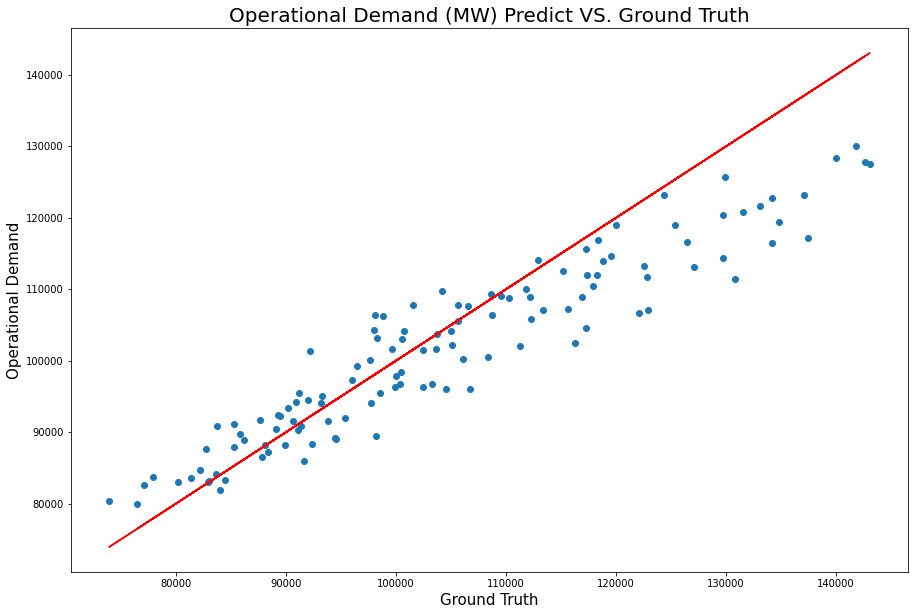

In [30]:
forest_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(forest_plot['Operational Demand (MW)'], forest_plot['predict'])
plt.plot(forest_plot['Operational Demand (MW)'],forest_plot['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [31]:
peak_day = 5 # number of top peak day we choose
peak_true = agg_forest.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = agg_forest.sort_values('predict',ascending=False)[:peak_day]
peak_predict = agg_forest[agg_forest['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.8


In [45]:
peak_true # true peak4

,Date,Operational Demand (MW),predict
77,2022-02-16,143068.538,127583.554548
65,2022-02-04,142620.646,127784.460779
51,2022-01-21,141839.600,130036.217513
49,2022-01-19,139949.878,128333.863466
26,2021-12-27,137419.324,117187.231714


In [46]:
peak_predict # predict that higher than threshold

,Date,Operational Demand (MW),predict
49,2022-01-19,139949.878,128333.863466
51,2022-01-21,141839.600,130036.217513
64,2022-02-03,129938.672,125643.526197
65,2022-02-04,142620.646,127784.460779
77,2022-02-16,143068.538,127583.554548


## Forecast

In [32]:
# %run -i 'fetch_forecast.py'

In [33]:
# fore = pd.read_csv('forecast.csv', index_col = 0)
# fore.head()

In [34]:
# fore

In [35]:
# fore['timestamp'] = fore.index
# fore = create_time_features(fore)
# fore_set = fore[x_col]
# predict_fore = grid_forest.predict(fore_set)
# fore_predict = pd.DataFrame()
# fore_predict['predict'] = predict_fore
# fore_predict.index = fore['timestamp']
# fore_predict


In [36]:
# fore_predict.plot.line(figsize = (25,10), color = 'blue',alpha = 0.7)
# plt.show()

In [37]:
# fore_predict['Date','time'] = fore_predict.index.str.split(" ",expand=True)
# fore_predict[['Date', 'time']] = fore_predict[('Date', 'time')].apply(pd.Series)

# fore_predict = fore_predict.drop(labels=['time',('Date','time')], axis=1)
# agg_fore = pd.DataFrame(fore_predict.groupby(['Date'])['predict'].sum().reset_index())

In [38]:
# fore_plot = agg_fore.copy()
# fore_plot.index = fore_plot['Date']
# fore_plot.drop('Date',axis=1)

In [39]:
# fore_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
# plt.show()

## SHAP Explain

In [40]:
# shap.initjs()
# row_choose = 3
# explainer = shap.TreeExplainer(grid_forest.best_estimator_)
# shap_values = explainer.shap_values(X_test)
# shap.force_plot(explainer.expected_value, shap_values[row_choose], X_test.iloc[row_choose])

In [41]:
# shap.force_plot(explainer.expected_value, shap_values,X_test)

In [42]:
# shap_values = shap.TreeExplainer(grid_forest.best_estimator_).shap_values(X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [43]:
# shap.summary_plot(shap_values, X_test)

In [44]:
# # Part
# shap.dependence_plot('Max Hum', shap_values, X_test)